<a href="https://colab.research.google.com/github/marcin-mulawa/deep_learning-cdv/blob/main/Rice_Image_Classifier_3CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed
from shutil import copyfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL

# Download data
!wget --trust-server-names https://www.muratkoklu.com/datasets/vtdhnd09.php

# Extract the archive
zip_ref = zipfile.ZipFile('Rice_Image_Dataset.zip', 'r')
zip_ref.extractall('/tmp')

zip_ref.close()

--2022-06-01 17:52:55--  https://www.muratkoklu.com/datasets/vtdhnd09.php
Resolving www.muratkoklu.com (www.muratkoklu.com)... 185.179.25.150
Connecting to www.muratkoklu.com (www.muratkoklu.com)|185.179.25.150|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: Rice_Image_Dataset.zip [following]
--2022-06-01 17:52:57--  https://www.muratkoklu.com/datasets/Rice_Image_Dataset.zip
Reusing existing connection to www.muratkoklu.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 229550800 (219M) [application/zip]
Saving to: ‘Rice_Image_Dataset.zip’

Rice_Image_Dataset. 100%[===================>] 218.92M  16.0MB/s    in 15s     

2022-06-01 17:53:12 (14.8 MB/s) - ‘Rice_Image_Dataset.zip’ saved [229550800/229550800]



In [ ]:
!ls /tmp/Rice_Image_Dataset

Arborio  Basmati  Ipsala  Jasmine  Karacadag  Rice_Citation_Request.txt


In [ ]:
source_path = '/tmp/Rice_Image_Dataset'

source_arborio_path = os.path.join(source_path, 'Arborio')
source_basmati_path = os.path.join(source_path, 'Basmati')
source_ipsala_path = os.path.join(source_path, 'Ipsala')
source_jasmine_path = os.path.join(source_path, 'Jasmine')
source_karacadag_path = os.path.join(source_path, 'Karacadag')

arborio_files = os.listdir(source_arborio_path)
basmati_files = os.listdir(source_basmati_path)
ipsala_files = os.listdir(source_ipsala_path)
jasmine_files = os.listdir(source_jasmine_path)
karacadag_files = os.listdir(source_karacadag_path)

print(f"There are {len(arborio_files)} images of Arborio.")
print(f"There are {len(basmati_files)} images of Basmati.")
print(f"There are {len(ipsala_files)} images of Ipsala.")
print(f"There are {len(jasmine_files)} images of Jasmine.")
print(f"There are {len(karacadag_files)} images of Karacadag.")

There are 15000 images of Arborio.
There are 15000 images of Basmati.
There are 15000 images of Ipsala.
There are 15000 images of Jasmine.
There are 15000 images of Karacadag.


In [ ]:
import imagesize
import numpy as np
print(np.unique([imagesize.get(os.path.join(source_arborio_path, file)) for file in arborio_files], axis=0))
print(np.unique([imagesize.get(os.path.join(source_basmati_path, file)) for file in basmati_files], axis=0))
print(np.unique([imagesize.get(os.path.join(source_ipsala_path, file)) for file in ipsala_files], axis=0))
print(np.unique([imagesize.get(os.path.join(source_jasmine_path, file)) for file in jasmine_files], axis=0))
print(np.unique([imagesize.get(os.path.join(source_karacadag_path, file)) for file in karacadag_files], axis=0))

[[250 250]]
[[250 250]]
[[250 250]]
[[250 250]]
[[250 250]]


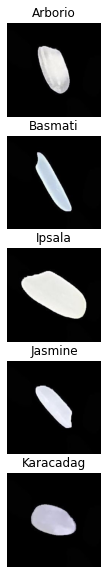

In [ ]:
i = random.randint(0, len(arborio_files)-1)

fig, axs = plt.subplots(5, figsize=(5,10))

img_arborio = mpimg.imread(os.path.join(source_arborio_path,arborio_files[i]))
axs[0].set_title('Arborio')
axs[0].axis('Off')
axs[0].imshow(img_arborio)

img_basmati = mpimg.imread(os.path.join(source_basmati_path,basmati_files[i]))
axs[1].set_title('Basmati')
axs[1].axis('Off')
axs[1].imshow(img_basmati)

img_ipsala = mpimg.imread(os.path.join(source_ipsala_path,ipsala_files[i]))
axs[2].set_title('Ipsala')
axs[2].axis('Off')
axs[2].imshow(img_ipsala)

img_jasmine = mpimg.imread(os.path.join(source_jasmine_path,jasmine_files[i]))
axs[3].set_title('Jasmine')
axs[3].axis('Off')
axs[3].imshow(img_jasmine)

img_karacadag = mpimg.imread(os.path.join(source_karacadag_path,karacadag_files[i]))
axs[4].set_title('Karacadag')
axs[4].axis('Off')
axs[4].imshow(img_karacadag)

In [ ]:
from matplotlib import test
# Define root directory
root_dir = '/tmp/Rice_Image'
training_dir = os.path.join(root_dir, 'training')
validation_dir = os.path.join(root_dir, 'validation')
test_dir = os.path.join(root_dir, 'test')

def create_train_val_test_dirs(training_path, validation_path, test_path):
  """
  Creates directories for the train and test sets
  
  Args:
    training_path (string) - the train directory path to create subdirectories from
    validation_path (string) - the validation directory path to create subdirectories from
    test_path (string) - the test directory path to create subdirectories from

  Returns:
    None
  """  

  categories = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
  for category in categories:
    os.makedirs(os.path.join(training_path, category), exist_ok=True)
    os.makedirs(os.path.join(validation_path, category), exist_ok=True)
    os.makedirs(os.path.join(test_path, category), exist_ok=True)

  
create_train_val_test_dirs(training_dir, validation_dir, test_dir)

In [ ]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/Rice_Image/validation
/tmp/Rice_Image/test
/tmp/Rice_Image/training
/tmp/Rice_Image/validation/Ipsala
/tmp/Rice_Image/validation/Basmati
/tmp/Rice_Image/validation/Jasmine
/tmp/Rice_Image/validation/Karacadag
/tmp/Rice_Image/validation/Arborio
/tmp/Rice_Image/test/Ipsala
/tmp/Rice_Image/test/Basmati
/tmp/Rice_Image/test/Jasmine
/tmp/Rice_Image/test/Karacadag
/tmp/Rice_Image/test/Arborio
/tmp/Rice_Image/training/Ipsala
/tmp/Rice_Image/training/Basmati
/tmp/Rice_Image/training/Jasmine
/tmp/Rice_Image/training/Karacadag
/tmp/Rice_Image/training/Arborio


In [ ]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, TEST_DIR, SPLIT_SIZE):

  """
  Splits the data into train and test sets
  
  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training
    
  Returns:
    None
  """
  filenames = []
  for filename in os.listdir(SOURCE_DIR):
      if os.path.getsize(os.path.join(SOURCE_DIR, filename)) > 0:
          filenames.append(filename)
      else:
          print(f"{filename} is zero length, so ignoring.")

  shuffled_filenames = random.sample(filenames, len(filenames))

  idx = int(len(shuffled_filenames) * SPLIT_SIZE)

  for filename in filenames[:idx]:
      copyfile(os.path.join(SOURCE_DIR, filename), os.path.join(TRAINING_DIR, filename))
  validation_test = filenames[idx:]

  half = len(validation_test) // 2
  for filename in validation_test[:half]:
      copyfile(os.path.join(SOURCE_DIR, filename), os.path.join(VALIDATION_DIR, filename))

  for filename in validation_test[half:]:
      copyfile(os.path.join(SOURCE_DIR, filename), os.path.join(TEST_DIR, filename))

In [ ]:
# Test your split_data function

# Define paths
training_arborio_path = os.path.join(training_dir, "Arborio")
training_basmati_path = os.path.join(training_dir, "Basmati")
training_ipsala_path = os.path.join(training_dir, 'Ipsala')
training_jasmine_path = os.path.join(training_dir, 'Jasmine')
training_karacadag_path = os.path.join(training_dir, 'Karacadag')

validation_arborio_path = os.path.join(validation_dir, "Arborio")
validation_basmati_path = os.path.join(validation_dir, "Basmati")
validation_ipsala_path = os.path.join(validation_dir, 'Ipsala')
validation_jasmine_path = os.path.join(validation_dir, 'Jasmine')
validation_karacadag_path = os.path.join(validation_dir, 'Karacadag')

test_arborio_path = os.path.join(test_dir, "Arborio")
test_basmati_path = os.path.join(test_dir, "Basmati")
test_ipsala_path = os.path.join(test_dir, 'Ipsala')
test_jasmine_path = os.path.join(test_dir, 'Jasmine')
test_karacadag_path = os.path.join(test_dir, 'Karacadag')



# Define proportion of ibasmages used for training
split_size = .8

# Run the function
split_data(source_arborio_path, training_arborio_path, validation_arborio_path, test_arborio_path, split_size)
split_data(source_basmati_path, training_basmati_path, validation_basmati_path, test_basmati_path, split_size)
split_data(source_ipsala_path, training_ipsala_path, validation_ipsala_path, test_ipsala_path, split_size)
split_data(source_jasmine_path, training_jasmine_path, validation_jasmine_path, test_jasmine_path, split_size)
split_data(source_karacadag_path, training_karacadag_path, validation_karacadag_path, test_karacadag_path, split_size)

# Check that the number of images matches the expected output
print(f"\n\nThere are {len(os.listdir(training_arborio_path))} images of arborio for training")
print(f"There are {len(os.listdir(training_basmati_path))} images of basmati for training")
print(f"There are {len(os.listdir(training_ipsala_path))} images of ipsala for training")
print(f"There are {len(os.listdir(training_jasmine_path))} images of jasmine for training")
print(f"There are {len(os.listdir(training_karacadag_path))} images of karacadag for training")

print('\n')

print(f"There are {len(os.listdir(validation_arborio_path))} images of arborio for validation")
print(f"There are {len(os.listdir(validation_basmati_path))} images of basmati for validation")
print(f"There are {len(os.listdir(validation_ipsala_path))} images of ipsala for validation")
print(f"There are {len(os.listdir(validation_jasmine_path))} images of jasmine for validation")
print(f"There are {len(os.listdir(validation_karacadag_path))} images of karacadag for validation")

print('\n')

print(f"There are {len(os.listdir(test_arborio_path))} images of arborio for test")
print(f"There are {len(os.listdir(test_basmati_path))} images of basmati for test")
print(f"There are {len(os.listdir(test_ipsala_path))} images of ipsala for test")
print(f"There are {len(os.listdir(test_jasmine_path))} images of jasmine for test")
print(f"There are {len(os.listdir(test_karacadag_path))} images of karacadag for test")




There are 12000 images of arborio for training
There are 12000 images of basmati for training
There are 12000 images of ipsala for training
There are 12000 images of jasmine for training
There are 12000 images of karacadag for training


There are 1500 images of arborio for validation
There are 1500 images of basmati for validation
There are 1500 images of ipsala for validation
There are 1500 images of jasmine for validation
There are 1500 images of karacadag for validation


There are 1500 images of arborio for test
There are 1500 images of basmati for test
There are 1500 images of ipsala for test
There are 1500 images of jasmine for test
There are 1500 images of karacadag for test


In [ ]:
# GRADED FUNCTION: train_val_generators
def train_val_test_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR):
  """
  Creates the training and validation data generators
  
  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the validation images
    TEST_DIR (string): directory path containing the testing images

  Returns:
    train_generator, validation_generator, test_generator - tuple containing the generators
  """

  train_datagen = ImageDataGenerator(rescale=1/255.,
                                     rotation_range=40,
                                     width_shift_range=.2,
                                     height_shift_range=.2,
                                     shear_range=.2,
                                     zoom_range=.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=128,
                                                      class_mode='categorical',
                                                      target_size=(250, 250))

  validation_datagen = ImageDataGenerator(rescale=1/255.)

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=128,
                                                                class_mode='categorical',
                                                                target_size=(250, 250))
  test_datagen = ImageDataGenerator(rescale=1/255.)

  test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                    batch_size=1,
                                                    class_mode='categorical',
                                                    target_size=(250, 250))
  
  return train_generator, validation_generator, test_generator


In [ ]:
train_generator, validation_generator, test_generator = train_val_test_generators(training_dir, validation_dir, test_dir)

Found 60000 images belonging to 5 classes.
Found 7500 images belonging to 5 classes.
Found 7500 images belonging to 5 classes.


In [ ]:
set_seed(20)

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    Conv2D(64, (3,3), activation='relu', input_shape=(250, 250, 3)),
    MaxPooling2D(2, 2),
    # The second convolution
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # The third convolution
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # The fourth convolution
    # Conv2D(128, (3,3), activation='relu'),
    # MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    Flatten(),
    Dropout(0.5),
    # 512 neuron hidden layer
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 128)      0

In [ ]:
from gc import callbacks
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callback = EarlyStopping(
    patience=3,
    mode='auto',
    monitor='val_loss',
    restore_best_weights=True
)

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks = [callback])

Epoch 1/15
469/469 [==============================] - 795s 2s/step - loss: 0.4610 - accuracy: 0.8102 - val_loss: 0.0868 - val_accuracy: 0.9752
Epoch 2/15
469/469 [==============================] - 789s 2s/step - loss: 0.1650 - accuracy: 0.9403 - val_loss: 0.0664 - val_accuracy: 0.9792
Epoch 3/15
469/469 [==============================] - 789s 2s/step - loss: 0.0874 - accuracy: 0.9693 - val_loss: 0.0674 - val_accuracy: 0.9772
Epoch 4/15
469/469 [==============================] - 793s 2s/step - loss: 0.0695 - accuracy: 0.9759 - val_loss: 0.0318 - val_accuracy: 0.9896
Epoch 5/15
469/469 [==============================] - 786s 2s/step - loss: 0.0646 - accuracy: 0.9779 - val_loss: 0.0597 - val_accuracy: 0.9787
Epoch 6/15
469/469 [==============================] - 801s 2s/step - loss: 0.0595 - accuracy: 0.9792 - val_loss: 0.1272 - val_accuracy: 0.9588
Epoch 7/15
469/469 [==============================] - 786s 2s/step - loss: 0.0495 - accuracy: 0.9828 - val_loss: 0.1447 - val_accuracy: 0.9472

In [ ]:
from google.colab import files
model.save("tf_3cnn_model.h5")
files.download("tf_3cnn_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

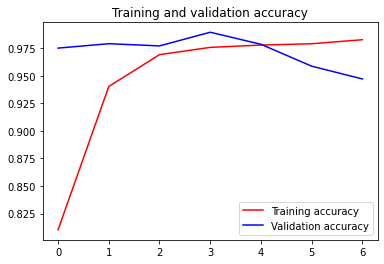

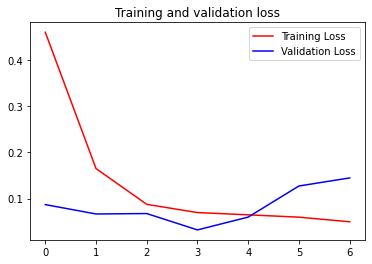

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
measures = model.evaluate(test_generator, verbose=1, return_dict=True)

7500/7500 [==============================] - 35s 5ms/step - loss: 0.0373 - accuracy: 0.9875


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(250, 250))

Found 7500 files belonging to 5 classes.


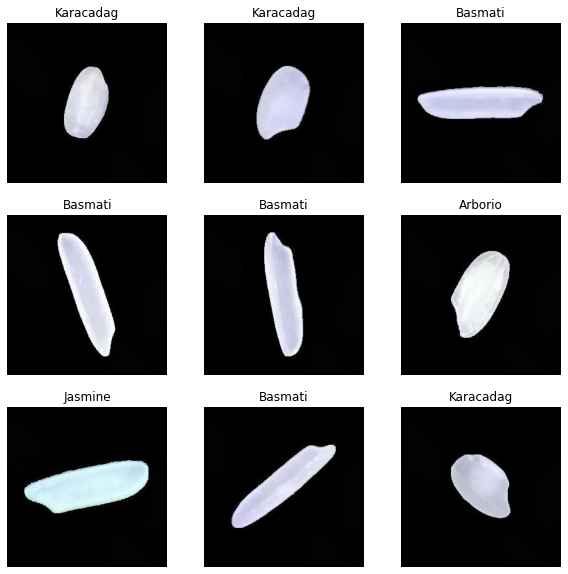

In [ ]:
import matplotlib.pyplot as plt

class_names = test_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
y_pred = []
y_true = []
stop_iter = len(test_generator)-1
for idx, (image, label) in enumerate(test_generator):
  y_pred.append(np.argmax(model.predict(image)))
  y_true.append(np.argmax(label))
  if idx == stop_iter:
    break


<Figure size 1872x1872 with 0 Axes>

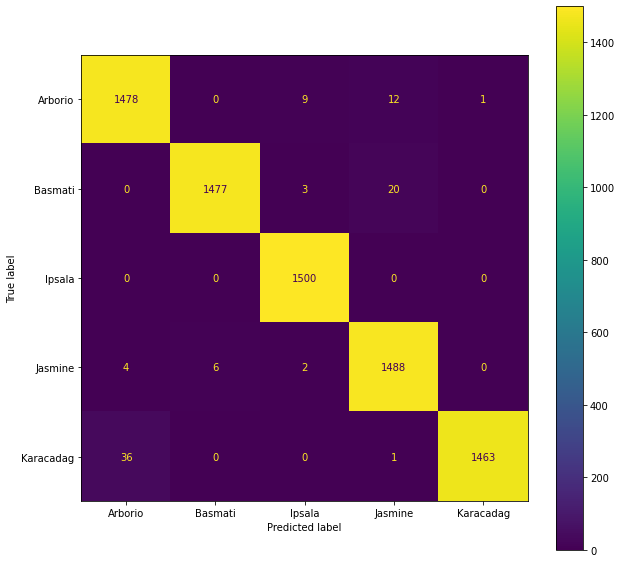

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.figure(figsize=(26,26))
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=list(test_generator.class_indices))
fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)